# Ejercicio de aplicación VECM

En este tutorial aplicaremos los conceptos más relevantes de los modelos vectoriales autoregresivos con corrección a la deriva (VECM).Comenzaremos con la importación de los datos y la visualización de los mismos. Posteriormente, aplicaremos las pruebas de cointegración a manera de saber si el sistema posee dicha propiedad de cointegración y si con ello, la aplicabilidad del modelo. Continuaremos con la aplicación de la función de regresión, donde veremos que hay una particular que ayuda a trabajar con los modelos VECM, empleando las funciones de las regresiones VAR. Avanzaremos con la interpretación, pronóstico y conclusiones generales.

**Contenido**
1. [Datos y Modelamiento:](#1)
    1. [Importación de librerías requeridas](#2)
    1. [Importacion de datos](#3)
    1. [ Visualización de los datos](#4)
1. [Nivel autorregresivo](#5)
1. [Prueba cointegración:](#6)
1. [Dickey-Fuller Test](#7)
1. [Modelo VECM](#8)
1. [Análisis Impulso-Respuesta: Impulse response](#9)
1. [Predicción](#10)
    
    
      


<a id="1"></a> <br>
## 1. Datos y Modelamiento

En esta primera sección abordaremos la importación de librerías, datos y las pruebas estadísticas para determinar el nivel regresivo, condición de cointergración y estacionariedad.

<a id="2"></a> <br>
###  A. Importacion de librerías requeridas

En esta sección importamos todas las librerías necesarias.

In [21]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
library(MTS)
library(urca)
library(vars)
library(tsDyn)
options(warn = - 1) 

<a id="3"></a> <br>
### B.Importacion de datos

Empelaremos la función de obtención de datos de yahoo finance.

In [22]:
# Especificamos las fechas de inicio y fin.
start<-format(as.Date("2018-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-11-30"),"%Y-%m-%d")

#--------- Funcion de obtención de datos, particularmente los datos de precios de cierre.
precio<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interis:
  datos<-datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

#### Llamar la funcion para cada activo particular:

Llamamos los activos de interés.

In [23]:
# Importemos al ETF del Standard and Poors, el SPY, el índice alemán y el etf del Dow Jhones
precio("SBUX")  #Vanguard Long-Term Treasury Index Fund 
precio("MCD")  #Currency
precio("DIS") #Global X Russell 2000 ETF
##Llamamos por facilidad a nuestros activos:
in1= `SBUX`
in2=`MCD`
in3=`DIS`

<a id="4"></a> <br>
### C. Visualización de los datos

Empelamos la visualización de series, echando mano de la función dygraphs.

In [24]:
## Juntamos los datos, renombramos las columnas y las visualizamos:
prices<-merge.xts(`in1`, `in2`, `in3`,join='inner')%>% na.omit()
dim(prices)
colnames(prices)<-c("in1",  "in2", "in3")
dygraph(prices, main = "in1",  "in2", "in3") %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

[1] 985   3

HTML widgets cannot be represented in plain text (need html)

<a id="5"></a> <br>
### 2. Nivel Autorregresivo

Comencemos así, por identificar el nivel autorregresivo de los datos. Podemos aplicar la función de la librería vars o de MTS.

In [25]:
## Aplicamos la función de VARselect() de la librería vars, y también podemos usar la función de VARorder, de la librería de MTS.
library(vars)

nivelk=VARselect(prices, lag.max = 7, type = "const")
nivelk$selection
# O con MTS:
niv1=VARorder(prices)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     7      2      1      7

selected order: aic =  9 
selected order: bic =  1 
selected order: hq =  2 
Summary table:  
       p     AIC     BIC      HQ       M(p) p-value
 [1,]  0 14.9956 14.9956 14.9956     0.0000  0.0000
 [2,]  1  3.8708  3.9155  3.8878 10780.9069  0.0000
 [3,]  2  3.8331  3.9225  3.8671    53.9665  0.0000
 [4,]  3  3.8386  3.9727  3.8896    12.3307  0.1953
 [5,]  4  3.8412  4.0200  3.9092    15.0549  0.0894
 [6,]  5  3.8477  4.0712  3.9327    11.2503  0.2589
 [7,]  6  3.8477  4.1159  3.9497    17.3921  0.0429
 [8,]  7  3.8272  4.1402  3.9463    36.7375  0.0000
 [9,]  8  3.8198  4.1774  3.9558    24.3730  0.0037
[10,]  9  3.8160  4.2183  3.9690    20.8223  0.0135
[11,] 10  3.8183  4.2654  3.9884    14.9659  0.0919
[12,] 11  3.8231  4.3149  4.0102    12.6448  0.1793
[13,] 12  3.8294  4.3658  4.0334    11.2581  0.2584
[14,] 13  3.8365  4.4176  4.0575    10.3914  0.3197


Como podemos ver, podemos tener la elección entre p de 3, 4, 7 y 8. Elijamos p=3, por sencillez del modelo.

<a id="6"></a> <br>
## 3. Prueba cointegración:
Procedemos con la prueba de cointegración. Procedemos con la prueba de Johansen Test, para saber su existe una condición de cointegración en la cual, se pudiera optar por otro modelo.

In [26]:
#La función para la prueba de cointegraci´n es la de ca-jo().
#K es el número de lags para emplear en el modelo autorregresivo, donde el mínimo es de 2.
johatest=ca.jo(prices, type = "trace", K=2, ecdet ="none", spec = "longrun") #
summary(johatest)



###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.025826020 0.006871251 0.001687025

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  1.66  6.50  8.18 11.65
r <= 1 |  8.44 15.66 17.95 23.52
r = 0  | 34.16 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

           in1.l2    in2.l2      in3.l2
in1.l2  1.0000000  1.000000  1.00000000
in2.l2 -0.5453028  0.890594  0.08557106
in3.l2 -0.2574990 -1.798624 -0.23955878

Weights W:
(This is the loading matrix)

           in1.l2        in2.l2       in3.l2
in1.d 0.001242493 -0.0030079263 -0.002867202
in2.d 0.050581872 -0.0085764265 -0.001110718
in3.d 0.070188555  0.0004713564 -0.003844595


Como podemos observar, el estadístico de prueba en r=0, es mayor a todos los resultados de significancia de la prueba cuando r=0. Si continuamos, la hipótesis par ael rango de uno, se rechaza al 5% de significancia. Por lo cual, existe a lo mucho, dos relaciones de cointegración en el sistema.

Recordemos ahora, las pruebas de hipótesis para la prueba de Gragner, igualmente, revisemos si las series son estacionarias o no.

<a id="7"></a> <br>
## 4. Dickey-Fuller Test:
#### H0: La serie no es estacionaria
#### H1: La serie es estacionaria
Recuerda que para aplicar modelos autorregresivos, como en este caso CVAR, revisemos si las series son estacionarias o no.

In [27]:
#Aplicamos la función de adf.test() para probar la hipótesis nula de la exixtencia de una raíz uniataria.
adf.test(in1)
adf.test(in2)
adf.test(in3)


	Augmented Dickey-Fuller Test

data:  in1
Dickey-Fuller = -2.3714, Lag order = 9, p-value = 0.4211
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  in2
Dickey-Fuller = -3.226, Lag order = 9, p-value = 0.08344
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  in3
Dickey-Fuller = -2.0126, Lag order = 9, p-value = 0.573
alternative hypothesis: stationary


Como vemos, todas son no estacionarias, por lo que confirmamos que el modelo VECM, es un buen candidato para modelar el sistema.

<a id="8"></a> <br>
## 5. Modelo VECM

Ya identificado el nivel autorregresivo, igualmente confirmado que el modelo VECM es un modelo propicio para su uso en las series, procedemos a generar la regresión.

Para ello, recordemos las hiptesis de la prueba de Gragner.

## Prueba de Gragner:
#### H0: La serie x no es gragner-cause de la serie y.
#### H1: La serie x es Gragner-Cause de la serie y.

###### Término Gragner-cause: el valor de la serie x en un cierto rezago, es útil para 
###### predecir el valor de la serie y.
###### Es una prueba F, si el pvalor < alpha, rechazamos la nula, concluyendo que 
###### hay evidencia para decir que la serie x Gragner-Cause la serie y.

###### Ref interés: https://www.researchgate.net/post/Is-it-necessary-to-ensure-stationarity-of-all-time-series-variables-when-you-run-a-Vector-Autoregressive-VAR-Model 

In [28]:
# Aplicamos la función de regresión VECM al sistema. Especificamos el nivel regresivo y el nivel de rango. La librería de la función VECM es tsDyn.
library(tsDyn)

vecm1 = VECM(prices, lag=3, r=2, estim = ("ML"))
summary(vecm1)

#############
###Model VECM 
#############
Full sample size: 985 	End sample size: 981
Number of variables: 3 	Number of estimated slope parameters 36
AIC 3751.31 	BIC 3937.076 	SSR 15738.98
Cointegrating vector (estimated by ML):
             in1 in2        in3
r1  1.000000e+00   0 -0.8471848
r2 -3.208776e-17   1 -1.0744586


             ECT1                ECT2                Intercept         
Equation in1 -0.0012(0.0106)     -0.0030(0.0060)     0.1784(0.6362)    
Equation in2 0.0493(0.0206)*     -0.0382(0.0117)**   3.6764(1.2400)**  
Equation in3 0.0699(0.0184)***   -0.0380(0.0104)***  4.2783(1.1086)*** 
             in1 -1              in2 -1             in3 -1            
Equation in1 -0.0682(0.0440)     -0.0624(0.0220)**  0.0040(0.0216)    
Equation in2 -0.0499(0.0857)     -0.1412(0.0429)**  0.0290(0.0421)    
Equation in3 0.1879(0.0766)*     -0.0959(0.0384)*   -0.1051(0.0376)** 
             in1 -2              in2 -2              in3 -2             
Equation in1 0.0231(0.0443

Como podemos observar de los rsultados obtenidos, existe una relación a largo plazo (ECT1 y ECT2). Esto es, entre el primer activo y los otros dos a un 0.1 y 1 % de significancia, respectivamente.  Igualmente, mirando el resultado para ECT2, entre el el primer activo y sus mismos rezagos, así como el resto de activos. Podemos interpretar que, un cambio de una unidad en el precio del primer activo, genera una reacción negativa en los otros dos, exceptuando en él mismo. 
El resto de colmnas, podemos interpretar los resultados a diferentes rezagos. Por ejemplo, el primer rezago del primer activo, afecta en los precios de los otros dos, no siendo esto en el segundo activo pero sí en el tercero. Para segundos rezagos, el tercer activo afecta a todos excepto el primero. Podemos seguir interpretaciones similares hasta los terceros rezagos.

Ljung-Box Statistics:  
           m       Q(m)      df    p-value
 [1,]   1.0000    0.0377  -9.0000     1.00
 [2,]   2.0000    0.1361   0.0000     1.00
 [3,]   3.0000    0.7065   9.0000     1.00
 [4,]   4.0000   10.5052  18.0000     0.91
 [5,]   5.0000   23.8559  27.0000     0.64
 [6,]   6.0000   56.7523  36.0000     0.02
 [7,]   7.0000   83.6699  45.0000     0.00
 [8,]   8.0000  104.5827  54.0000     0.00
 [9,]   9.0000  119.2169  63.0000     0.00
[10,]  10.0000  130.7204  72.0000     0.00
[11,]  11.0000  144.4160  81.0000     0.00
[12,]  12.0000  159.1094  90.0000     0.00
[13,]  13.0000  166.5891  99.0000     0.00
[14,]  14.0000  181.3580 108.0000     0.00
[15,]  15.0000  189.4453 117.0000     0.00
[16,]  16.0000  199.0477 126.0000     0.00
[17,]  17.0000  205.9621 135.0000     0.00
[18,]  18.0000  219.6472 144.0000     0.00
[19,]  19.0000  241.2713 153.0000     0.00
[20,]  20.0000  253.4384 162.0000     0.00
[21,]  21.0000  261.3000 171.0000     0.00
[22,]  22.0000  270.1257 180.0

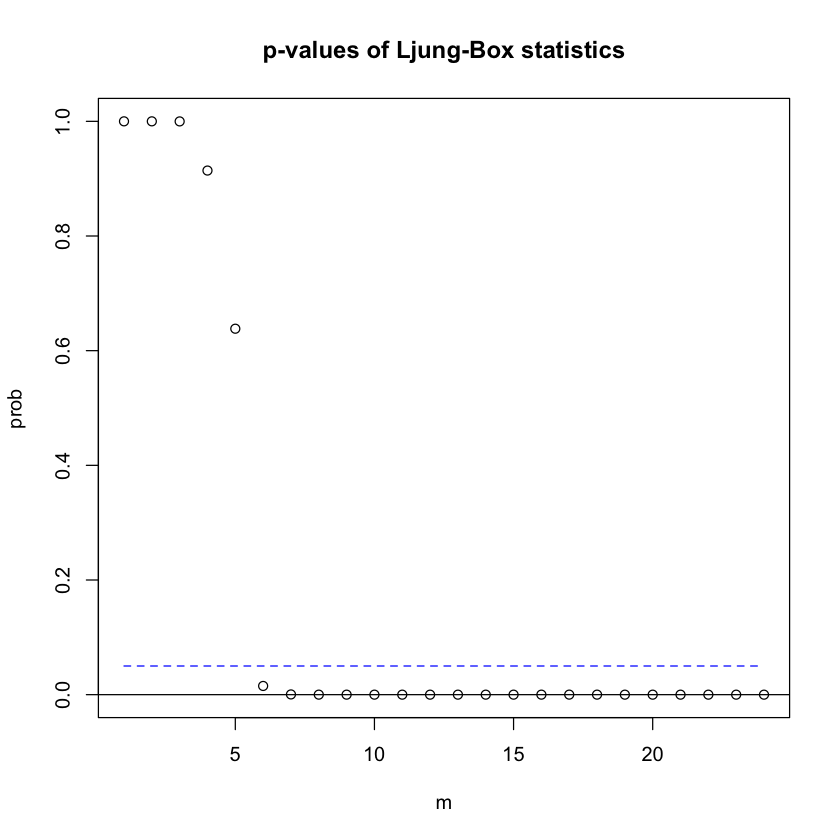

In [29]:
##Podemos revisar los residuales del modelo. Como es un modelo VECM con 3 rezagos en los activos, son 27 grados de libertad, como modelo no restrictivo. Además, se le suman los interceptos que son 3.
library(MTS)

resi2=vecm1$residuals
mq(resi2, adj=18)

Dados los valores de la prueba Ljung-Box, los residuales se ven ok, pues dan cobertura al modelo VECM con tres rezagos.

In [ ]:
#Podemos ver la correlación instantánea entre los activos.Como es un modelo no depurado, los grados de libertad son 27.
MTSdiag(vecm1, adj=30) 

[1] "Covariance matrix:"
     [,1] [,2] [,3]
[1,] 2.05 2.55 1.78
[2,] 2.55 7.79 3.14
[3,] 1.78 3.14 6.22
CCM at lag:  0 
      [,1]  [,2]  [,3]
[1,] 1.000 0.638 0.498
[2,] 0.638 1.000 0.451
[3,] 0.498 0.451 1.000
Simplified matrix: 
CCM at lag:  1 
. . . 
. . . 
. . . 
CCM at lag:  2 
. . . 
. . . 
. . . 
CCM at lag:  3 
. . . 
. . . 
. . . 
CCM at lag:  4 
. . . 
. . - 
. . . 
CCM at lag:  5 
. . . 
. . . 
. . . 
CCM at lag:  6 
- - . 
- - - 
. - . 
CCM at lag:  7 
+ + + 
+ + + 
. . + 
CCM at lag:  8 
. - . 
. . . 
- - . 
CCM at lag:  9 
+ + . 
. + . 
+ . . 
CCM at lag:  10 
. . . 
. . + 
. . . 
CCM at lag:  11 
. . . 
. . . 
+ . . 
CCM at lag:  12 
. + . 
. + . 
. . . 
CCM at lag:  13 
. . . 
. . . 
. . . 
CCM at lag:  14 
. + . 
+ + . 
. . . 
CCM at lag:  15 
. . . 
. . . 
. . . 
CCM at lag:  16 
. . . 
. + . 
. . . 
CCM at lag:  17 
. . . 
. . . 
. . . 
CCM at lag:  18 
. - . 
- - . 
. . . 
CCM at lag:  19 
. . . 
. + . 
. . . 
CCM at lag:  20 
. . . 
. . . 
. . . 
CCM at lag:  21 

 2


Hit Enter for p-value plot of individual ccm:  


Podemos ver un efecto instantaneo entre el primer y segundo activo.

<a id="9"></a> <br>
### 6. Análisis de Impulso Respuesta

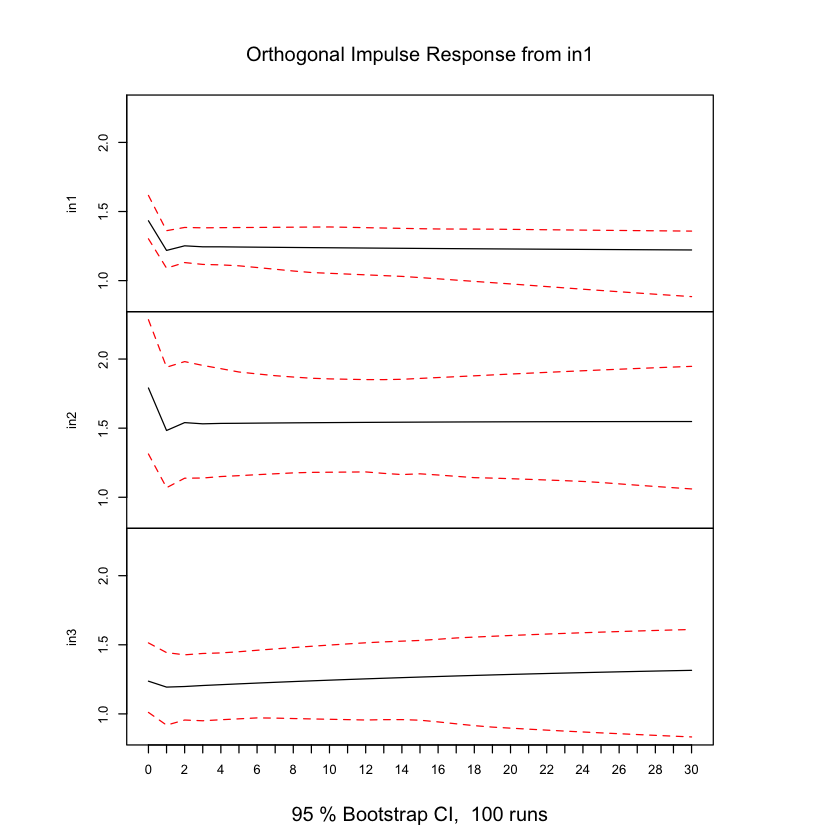

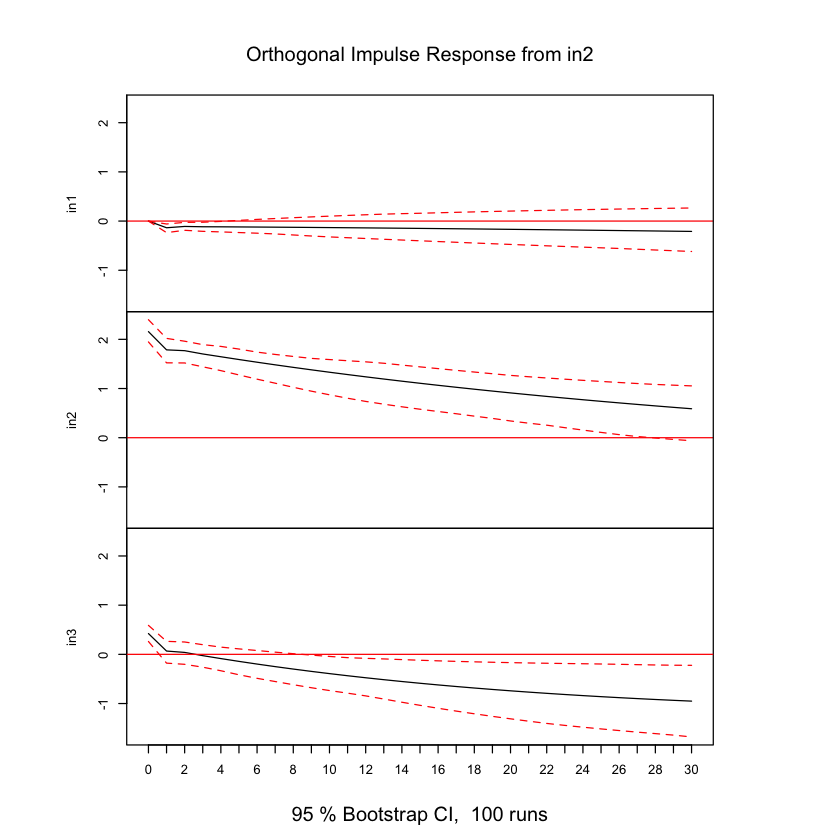

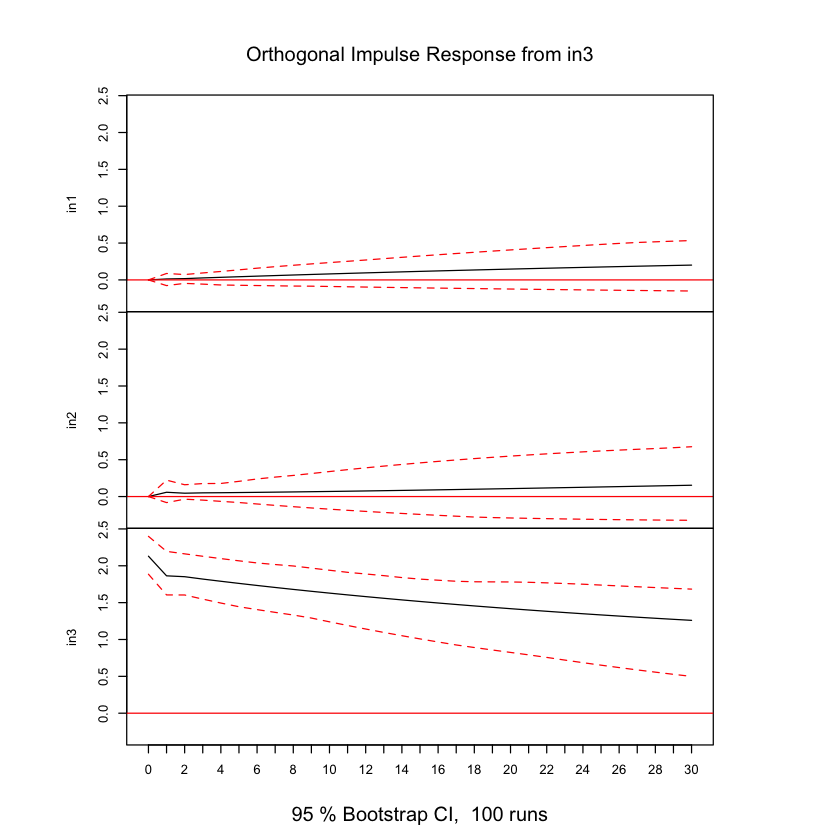

In [30]:
#Aplicamos la función de impulso respuesta al sistema. Para ello, se requiere "transformar" el modelo VECM a un objeto tipo VAR.
varmod1 = vec2var(johatest, r=2)
#Posteriormente, aplicamos la función de interés:
m1irf = irf(varmod1, n.ahead = 30, boot = TRUE)
plot(m1irf)  #predicción eje Y: es la var dependiente, acorde el impulso X.

Como podemos observar de los resultados, un cambio en el precio del primer activo, generaría cambios sutiles en los demás. Un cambio en el segundo generaría un incremento inicial en el primero y un sutil decremento en el tercero; mientras que un cambio en el tercero, generaría un incremento inicial en todos los activos seguidos de caídas en los precios de los dos iniciales.

Ahora, procedamos con el análisis de impulso respuesta con el método de OIR (Orthogonal Impulse Response), que involucra en su proceso, una descomposición de Cholesky, que es la función chol(). Para esta función, empleaos el objeto de la función VECM.

In [31]:
# Con OIR (orthogonal- Imp-Resp) Se descompone la matriz de vari-cov a una matriz triangular inferior con elementos positivos diagonales
suma = summary(vecm1)
# suma
choles = t(chol(suma$sigma))
choles  # Ej. un choque en JPY genera un efecto contemporáneo en Rusell, pero no viceversa.
# o, un choque en el rendimiento de los bonos del tesoro genera un efecto contemporáneo en divisa JPY y en Rusell
# Para ver los otros efectos, cambiar el orden de los datos.

1.439788,0.0000000,0.000000
1.791127,2.1604131,0.000000
1.249381,0.4346827,2.131687


In [32]:
#Similar con VAR. Para esta función, debemos emplear un objeto tipo VAR, por lo que generamos su regresión. 
#Cuando contamos con modelos VECM, es preferible emplear el tipo de funciones anteriores, y esta, para posibles referencias de similitudes.
modVAR= VAR(prices, p = 3, type="const")
model_sum=summary(modVAR)
chole = t(chol(model_sum$covres))
chole

,in1,in2,in3
in1,1.437409,0.0000000,0.000000
in2,1.791999,2.1656461,0.000000
in3,1.244148,0.4240431,2.135354


Lo que podemos interpretar de estos resultados, son los efectos inmediatos de cambios contemporánes en los activos. Por ejemplo, un cambio en el primer activo, genera un efecto contemporáneo con correlación inmedianta negativa en el segundo a un nivel de significancia del 5%. Estos resultados son coherentes a los que obtuvimos previamente, mediante la función de MTSdiag(). 

<a id="10"></a> <br>
### 7. Predicción

Podemos generar una predicción del modelo VECM. Para ello, podemos emplear la función predict().

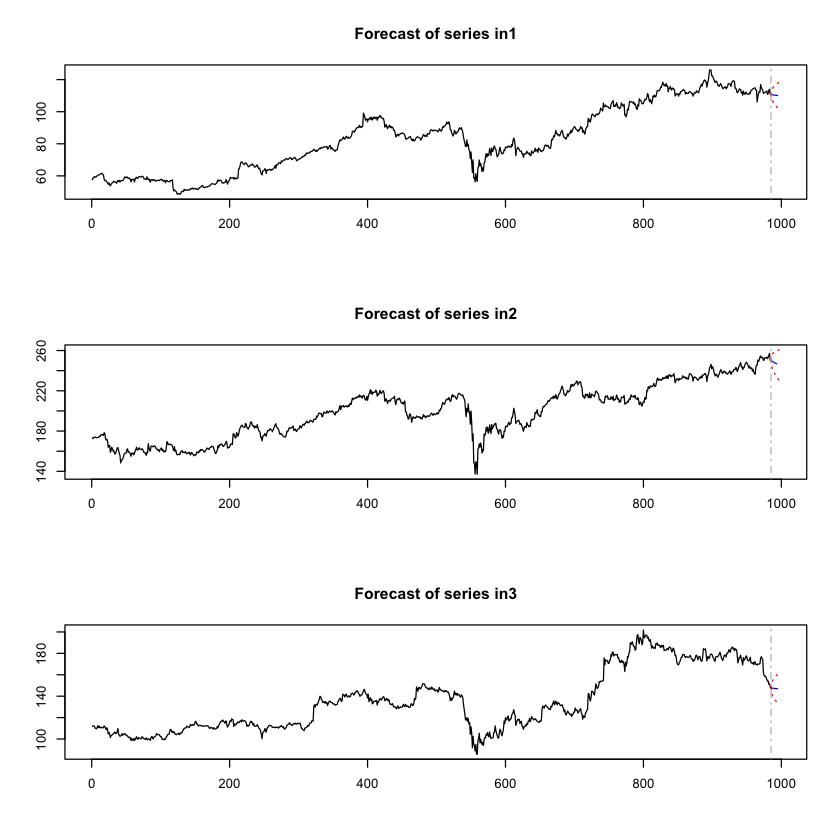

In [34]:
#Empleamos el modelo transforado del VECM al VAR, para poder emplear esta función. Igualmente, podemos generar una visualización del pronóstico de lso activos.
pred=predict(varmod1, n.ahead = 12, ci = 0.95)
plot(pred)

Ya que, no diferenciamos los datos, la función de recuperación de nivel no es necesaria en este caso, como lo fue en el VAR.

En este tutorial aprendimos a aplicar el método de VECM a tres series de activos. Ya que, reflejaban una relación de cointegración y eran no estacionarias (de orden I(1), que se puede demostrar sencillamente), se aplicó la metodología de VECM. Obtuvimos resultados de regresión, aplicamos la función de impulso respuesta y generamos su predicción. En esta última ya que, no se diferenciaron las series, no tuvimos que aplicar la función de recuperación de nivel al pronóstico.